In [149]:
"""
OBJETIVO: Centralizar los resultados, generar metricas adecuadas a cada modelo para luego poder compararlos.
          De esta forma obtener el modelo mas adecuado para el proyecto.
"""

'\nOBJETIVO: Centralizar los resultados, generar metricas adecuadas a cada modelo para luego poder compararlos.\n          De esta forma obtener el modelo mas adecuado para el proyecto.\n'

In [150]:
"""
from netCDF4 import Dataset, num2date
import cartopy.crs as ccrs
import cartopy.feature as cf
"""

from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import re
import numpy as np
import glob
import time
import os

In [154]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/NewTesis'

In [155]:
def crearDir(path, newDir):
    try:
        pathT = os.path.join(path, newDir)
        os.mkdir(pathT)
        return pathT
    except FileExistsError:
        return pathT
        pass
    except:
        print(f"No se pudo crear el directorio: {newDir}")
        pritn(f'Path base: {path}')
        pritn(f'Nuevo    : {newDir}')        
        return None

In [156]:
def writeExcel(file_out, infoDF, statDF):    
    writer = pd.ExcelWriter(file_out, engine = 'xlsxwriter')       
    infoDF.to_excel(writer, sheet_name = 'Informacion', index=False)
    for idModel, data in statDF.items():
        data.to_excel(writer, sheet_name = f'{idModel}', index=False)

    writer.save()    

In [157]:
def savetoFile(path_base,tipo, infoDf, statDF):
    path_out = crearDir(f'{path_base}/Archivos/Modelos', tipo)
    
    
    # Tests con 1 input
    head1 = infoDf[infoDf['inputs']=="['imagen']"] 
    if not head1.empty:
        data1 = {k: v for k, v in statDF.items() if k in head1['ModelID'].unique()}
        file_out1 = f'{path_out}/Stats_{tipo}-1_202204.xlsx'
        writeExcel(file_out1, head1, data1)
    
    # Test con 2 inputs
    head2 = infoDf[infoDf['inputs']=="['imagen', '99%']"] 
    if not head2.empty:
        data2 = {k: v for k, v in statDF.items() if k in head2['ModelID'].unique()}
        file_out2 = f'{path_out}/Stats_{tipo}-2_202204.xlsx'
        writeExcel(file_out2, head2, data2)
    
    # Test con 3 inputs
    head3 = infoDf[infoDf['inputs']=="['imagen', '99%', 'altura']"] 
    if not head3.empty:
        data3 = {k: v for k, v in statDF.items() if k in head3['ModelID'].unique()}
        file_out3 = f'{path_out}/Stats_{tipo}-3_202204.xlsx'
        writeExcel(file_out3, head3, data3)
    
    return path_out

In [158]:
def mergeFileStats(listFiles,path_base,tipo='Umbral'):
    infoDF = []
    statDF = {}
    for file in listFiles:
        headDF = pd.read_excel(file,nrows=1)
        headDF = headDF.dropna(axis='columns', how ='all')
        
        dataDF = pd.read_excel(file,skiprows=5)
        dataDF = dataDF.dropna(axis='columns', how ='all')
        
        headDF['best_val_acc'] = dataDF['val_acc'].max()
        infoDF.append(headDF)
        statDF[headDF['ModelID'][0]] = dataDF
    
    infoDF = pd.concat(infoDF)
    
    statFiles =  savetoFile(path_base,tipo, infoDF, statDF)
       
    
    return statFiles    

In [159]:
def selectTipoStats(df,tipo,ascending=False):
    dfT = df.sort_values(by=tipo, ascending=ascending).head(1)
    dfT['TIPO'] = tipo
    return dfT

In [160]:
def getDSStats(path_base,modelList,dsListT):
    print(f'\nESTADISTICAS DE LOS DATASETS')
    print('____________________________________')
    dsStats = {
        'idModel': [],
        'dsName' : [],
        'count'  : [],
        'mean'   : [],
        'std'    : [],
        'ceros'  : [],
        '_0-1'   : [],
        '_1-N'   : [],
        'max'    : [],
    }    
    
    list_set = set(dsListT)    
    dsList = (list(list_set))
    
    for i in range(len(dsList)):        
        dfDS = pd.read_csv(f'{dsList[i]}.csv')  
        print(f"DATASET {dsList[i].split('/')[-1]} SIN CEROS")
        print(f'Cantidad total: {dfDS["dato"].count()}')
        print(f'Cantidad ceros: {dfDS[dfDS["dato"]==0]["dato"].count()}')
        plt.hist(dfDS[dfDS['dato']!=0]['dato'])      
        plt.show()
        dsStats['idModel'].append(modelList[i]) 
        dsStats['dsName'].append(dsList[i].split('/')[-1]) 
        dsStats['count'].append(dfDS['dato'].count()) 
        dsStats['mean'].append(dfDS['dato'].mean()) 
        dsStats['std'].append(dfDS['dato'].std()) 
        dsStats['ceros'].append(dfDS[dfDS['dato']==0]['dato'].count()) 
        dsStats['_0-1'].append(dfDS[(dfDS['dato']>0) & (dfDS['dato']<=1)]['dato'].count()) 
        dsStats['_1-N'].append(dfDS[dfDS['dato']>1]['dato'].count()) 
        dsStats['max'].append(dfDS['dato'].max())      
        
        print(dsStats)
        print('---------------------------------------------------------')
    return pd.DataFrame(dsStats)

In [161]:
"""
RECOLLECION DE DATOS
"""

'\nRECOLLECION DE DATOS\n'

In [162]:
def summaryResultsFile(path_base, params):
    resultados = {}
    
    for model in params['models']:
        
        modelPath = f'{params["resultDir"]}/{model}/'        
        os.chdir(modelPath)
        listFiles = list(glob.glob('**/**/*.xlsx'))
        
        if model == 'Clasificacion':
            columns = ['project','epoca','idModel','C','T','M','DA','3D','Tipo','dsName','acc','acc_bal','loss','val_loss','val_TP','val_FP',
                        'val_FN','val_TN' , 'DS_len','TNR','TPR','PPV','NPV','F1']
            if params['V2']:
                columns = ['project','epoca','idModel','C','T','M','DA','3D','Tipo','dsName',
                           'acc','acc_bal','loss','val_loss','val_TP','val_FP',
                           'val_FN','val_TN' ,'TNR','TPR',
                           'TP','FP','FN','TN','train_acc_bal',
                           'train_TNR','train_TPR']
            
        elif model=='Regresion':
            columns = ['project','epoca','idModel','C','T','M','DA','3D','Tipo','dsName','loss','val_loss',
                       'mse','val_mse']   
         
            
        else:
            print("Debe indicar el modelo adecuado (Clasificacion / Regresion)")
        
            
        results = pd.DataFrame(columns=columns)
        
        
        for file in listFiles:
            #print(file)
            excelTemp = pd.read_excel(file, sheet_name=None)

            for k,v in excelTemp.items():
                if k=='Estadisticas':
                    break
                    headDF = pd.read_excel(file,nrows=1)
                    headDF = headDF.dropna(axis='columns', how ='all')
            
                    dataDF = pd.read_excel(file,skiprows=5)
                    dataDF = dataDF.dropna(axis='columns', how ='all')
                    
                    dataDF['epoca'] = dataDF['Unnamed: 0']
                    dataDF['idModel'] = headDF['ModelID'].iloc[0]
                    dataDF['C'] = f"{headDF['canales'].iloc[0]}"
                    dataDF['T'] = f"{headDF['tiempos'].iloc[0]}"
                    dataDF['M'] = f"{headDF['margen'].iloc[0]}"
                    
                    dataDF['DA'] = True if 'DA' in file else False                    
                    dataDF['3D'] = True if 'DA' in file else False
                    dataDF['Tipo'] = model
                    dataDF['dsName'] = -1
                    dataDF['project'] = file.split('\\')[0]
                    
                    results = pd.concat([results,dataDF[columns]],axis=0)
                    break
                    
                
                elif k != 'Informacion':
                    dfTemp = excelTemp[k]     
                    
                    dfTemp['epoca'] = dfTemp['Unnamed: 0']
                    dfTemp['idModel'] = k.split('-')[-1]
                    dfTemp['C'],dfTemp['T'] ,dfTemp['M'] = k.split('(')[1].split(')')[0].split('-')#replace('-','_')
                    
                    try:
                        dfTemp['DA'] = bool(excelTemp['Informacion']['DataAug'][0])
                    except:
                        dfTemp['DA'] = bool(excelTemp['Informacion']['DA'][0])
                        
                    dfTemp['3D'] = True if '3D' in file else False
                    dfTemp['Tipo'] = excelTemp['Informacion']['redTipo'][0]
                    dfTemp['dsName'] = excelTemp['Informacion']['dsName'][0]
                    dfTemp['project'] = file.split('\\')[0]
            
           
                    if model == 'Clasificacion':                        
                        if params['V2'] and not 'TN' in dfTemp.columns:
                            break
                      
                        #dfTemp['DS_len'] = dfTemp['val_TN'] + dfTemp['val_TP'] + dfTemp['val_FP'] + dfTemp['val_FN']
                        dfTemp['TNR'] = dfTemp['val_TN'] / (dfTemp['val_TN']+dfTemp['val_FP']) # Recall de la clase 0 (M02)
                        dfTemp['TPR'] =    dfTemp['val_TP'] / (dfTemp['val_TP']+dfTemp['val_FN'])  # Recall de la clase 1 (C02)
                        dfTemp['acc_bal'] =  (dfTemp['TNR'] + dfTemp['TPR']) / 2 
                        
                        if params['V2']:
                            dfTemp['train_TNR'] = dfTemp['TN'] / (dfTemp['TN']+dfTemp['FP']) # Recall de la clase 0 (M02)
                            dfTemp['train_TPR'] =    dfTemp['TP'] / (dfTemp['TP']+dfTemp['FN'])  # Recall de la clase 1 (C02)
                            dfTemp['train_acc_bal'] =  (dfTemp['train_TNR'] + dfTemp['train_TPR']) / 2 
                        
                        #dfTemp['PPV']  =  dfTemp['val_TP'] / (dfTemp['val_TP']+dfTemp['val_FP']) 
                        #dfTemp['NPV'] =  dfTemp['val_TN'] / (dfTemp['val_TN']+dfTemp['val_FN']) 
                        #dfTemp['F1'] =  2*(dfTemp['PPV'] * dfTemp['TPR']) / (dfTemp['PPV'] + dfTemp['TPR']) 
                    
                    results = pd.concat([results,dfTemp[columns]],axis=0)
                else:
                    pass                
        
        results.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/ReporteEstadisticas.csv',index=False)
        if model == 'Clasificacion':
            dfbyDS = results.groupby(['project','C','T','M']).mean()
            dfbyDS.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/ReporteEstadisticas_MEAN.csv')
            
        resultados[model]  = results
        
    return resultados

In [163]:
def getMatConfusion(df,p):       
    data = df
    
    print(f'\nRESUMEN DE ESTADISTICAS TOP  {p["top"]}')
    print(f'Criterio {p["criterio"]}')
    
    bestResults = []
    modelList = []
    dsList = []
    for i in range(p['top']):
        data = data.sort_values(p['criterio'], ascending=p['ascending'])
        if data.empty:
            break
        modelList.append([data['idModel'].head(1),i])        
        bestResults.append(data.iloc[0])
        dsList.append(data['dsName'].iloc[0])
        
        print(f'\nMatriz Confusion : N°: {i+1} -- {data["idModel"].iloc[0]} -- {data["dsName"].iloc[0]} -- C: {data["C"].iloc[0]} -- T: {data["T"].iloc[0]} -- M: {data["M"].iloc[0]} --{p["criterio"]}: {data[p["criterio"]].iloc[0]}')
        if p['model'] == 'Clasificacion':      
            if p['cm']:        
                cm = [[data['val_TP'].iloc[i],data['val_FN'].iloc[0]],
                      [data['val_FP'].iloc[i],data['val_TN'].iloc[0]]]        
        
                disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm),
                                       display_labels=['M02','C02'])
                disp.plot()
                plt.show()                 
        
        data = data[data['idModel']!=data['idModel'].iloc[0]]  
     
    return pd.DataFrame(bestResults),modelList, dsList
    

In [164]:
def summaryStats(path_base, params):      
    if params['redoStats']:
        results = summaryResultsFile(path_base, params)
    else:
        results = {}
        for model in params['models']:
            results[model] = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/ReporteEstadisticas.csv')
            
    
    print(f"Cantidad de datos {params['models'][0]}: {len(results[params['models'][0]])}")
    print(f"Cantidad de datos {params['models'][1]}: {len(results[params['models'][1]])}")
    print('---------------------------------------------------------')
    
    df  = results[params['model']]
    if params['drop']:
        df = df[~df[params['drop'][0]].isin(params['drop'][1])]
    if params['select']:
        df = df[df[params['select'][0]].isin(params['select'][1])]
    
    if params['groupBy']:
        bestResults = []    
        modelList = []
        groupColumn = df[params['groupBy']].unique().tolist()
        print(f"Se realizar estadistias por grupo: {params['groupBy']}")
        print(groupColumn)
        print('---------------------------------------------------------')
        print('---------------------------------------------------------')
        for group in groupColumn:
            print(f'Realizando graficas para  {group}')
            dfGrouped = df[df[params['groupBy']]==group]        
            bestR,modelL,dsList = getMatConfusion(dfGrouped, params)
            modelList = modelList + modelL
            bestResults.append(bestR)
            print('---------------------------------------------------------')
        bestResults = pd.concat(bestResults)
        
        
    else:
        bestResults,modelList,dsList = getMatConfusion(df,params)
    
    
    #return (modelList)
            
    print('---------------------------------------------------------')
    print(f'\nCOMPARACION RESULTADOS')    
        
    for comp in params['compare']:
        print(f'\nCOMPARACION :  {comp}\n')
        for idModel, pos in modelList:
            dfModel = df[df['idModel']==idModel.iloc[0]]
            if params['groupBy']:
                plt.plot(dfModel['epoca'],dfModel[comp],label=f"{dfModel[params['groupBy']].iloc[0]}-{pos+1}-{idModel.iloc[0]}")
            else: 
                plt.plot(dfModel['epoca'],dfModel[comp],label=f" -{pos+1}-{idModel.iloc[0]}")
            plt.xlabel('EPOCAS')

            plt.title(f'Comparacion de : {comp}')
            plt.legend()

        plt.show()
    
    print('---------------------------------------------------------')
    #dsStats = getDSStats(path_base,modelList,dsList)    
    #results.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/Reporte-Clasificacion.csv')
    
    return bestResults#,results,dsStats

In [165]:
params = {
    # General
    'resultDir': f'{path_base}/Archivos/Resultados/', # Direcotrio de resultados
    'models'   : ['Clasificacion', 'Regresion'],    
    'redoStats': True,            # True : Rehace las estadisticas, caso contrario solo lee los archivos de reportes
    'drop'     : [],#['dsName', 'CLASE_TrainDS_17'],    
    'select'   : [],
    
    # Stats
    'model'    : 'Regresion',
    'cm'       : False,        # SOLO en modelos de clasificacion
    'groupBy'  : '',        # Separa las estadisticas por ... (eg. Projecto, HP, DS, etc)
    'top'      : 1,
    'criterio' : 'val_loss',         
    'ascending': True,            # False =  mayor a menor              
    'compare'  : ['val_loss'],         # Realiza graficas para comparar       
    
    # DS   
    'dsStats'  : False,            # Realiza estadisticas del DS_Train
}


#bestResults = summaryStats(path_base, params)
#bestResults.sort_values('val_loss',ascending=False)

In [166]:
def graficaClasificacion(df, limites=[[0,1],[0,1]], name='V1' ,cuadrantes = False, legenda =True, train=False, legendName=False):
    #          3D-DA  3D-NO  2D-DA    2D-NO
    markers = ['o',   '.']                 # Diferenciar 3D - 2D

    colors  = {30:'b', 40:'g'}             # Diferenciar Margen

    fig, ax = plt.subplots()
    #bestModels = df['idModel'].unique().list()[:3]
    

    for i in df['DA'].unique().tolist():
        for j in df[df['DA']==i].index:
            if train:
                x = df['train_TNR'][j]
                y = df['train_TPR'][j]  
            else:
                x = df['TNR'][j]
                y = df['TPR'][j]  
                

            if df['3D'][j]:
                if df['DA'][j]:
                    marker = markers[0]            
                else:
                    marker = markers[1]
            else:
                if dfCLAS['DA'][j]:
                    marker = markers[2]
                else:
                    marker = markers[3]       
            if legendName[1]=='dsName':
                plt.plot(x,y , marker = marker,
                     label = f"{df[legendName[1]][j]}")        
            else:
                plt.plot(x,y , marker = marker, c=colors[int(df['M'][j])],
                     label = f"{df[legendName[1]][j]}-{bool(df['3D'][j])}-{bool(df['DA'][j])}")        
                     #           label = f"{df['C'][j]}-{df['M'][j]}-{df['T'][j]}-{bool(df['3D'][j])}-{bool(df['DA'][j])}")        

            
            
    
    if legenda:
        h = [plt.plot([],[], color="black", marker=v , ms=8, ls="")[0] for v in markers]
        leg = plt.legend(handles=h, labels=['DA', 'NO_DA'], loc=(1.03,0), title="Tipo")     
        ax.add_artist(leg)
        K = [plt.plot([],[], color=v , marker='o' , ms=8, ls="")[0] for k,v in colors.items()]
        leg2 = plt.legend(handles=K, labels=['M:30','M:40'],loc=(1.03,0.5), title="Margen")     
        ax.add_artist(leg2)
    if legendName[0]:
        if legendName[1]=='dsName':
            plt.legend(loc=(1.1,-0.1), title= 'Label')
        else:
            plt.legend(loc=(1.30,-0.1), title= 'Label')


    x = np.linspace(0, 1, 100)
    plt.plot(x, x + 0, '--r')  
    if cuadrantes:
        plt.plot(x, [0.5]*100, '--k')  
        plt.plot([0.5]*100, x, '--k') 
    
    plt.xlim(limites[0][0],limites[0][1])
    plt.ylim(limites[1][0],limites[1][1])
    if train:
        plt.title(f'Grafica de TPR vs TNR (Entrenamiento)')
    else:
        plt.title(f'Grafica de TPR vs TNR (Validacion)')
    plt.ylabel('TPR (C02)')
    plt.xlabel('TNR (M02)')
    plt.grid(linestyle='--')

    #plt.savefig(f'{path_base}/Archivos/Reportes/Plots/ClasificacionModeloComparacion.png')

    plt.show()

In [167]:
params = {
    # General
    'resultDir': f'{path_base}/Archivos/Resultados/', # Direcotrio de resultados
    'models'   : ['Clasificacion', 'Regresion'],    
    'redoStats': True,            # True : Rehace las estadisticas, caso contrario solo lee los archivos de reportes
    'drop'     : ['project', ['Clasificacion3D_Completo', 'ClasificacionTEST32_3D_V4',
                              'Clasificacion3D_V3','Clasificacion3D_V2','ClasificacionTEST32_3D_V4']],    
    'select'   : [],#['project',['']],
    'V2'       : True,            # Separa los que tengan train y validation stats
    
    # Stats
    'model'    : 'Clasificacion',
    'cm'       : False,        # SOLO en modelos de clasificacion
    'groupBy'  : 'project',        # Separa las estadisticas por ... (eg. Projecto, HP, DS, etc)
    'top'      : 3,
    'criterio' : 'acc_bal',         
    'ascending': False,            # False =  mayor a menor              
    'compare'  : [],         # Realiza graficas para comparar       
    
    # DS   
    'dsStats'  : False,            # Realiza estadisticas del DS_Train
}


bestResults = summaryStats(path_base, params)


Cantidad de datos Clasificacion: 1561
Cantidad de datos Regresion: 147
---------------------------------------------------------
Se realizar estadistias por grupo: project
['Clasificacion_3D_DA_ANAV2', 'Clasificacion_3D_V5', 'Clasificacion_DUD_3D_DA']
---------------------------------------------------------
---------------------------------------------------------
Realizando graficas para  Clasificacion_3D_DA_ANAV2

RESUMEN DE ESTADISTICAS TOP  3
Criterio acc_bal

Matriz Confusion : N°: 1 -- 20220526_001024 -- CLASE_TrainDS_2 -- C: 3 -- T: 4 -- M: 40 --acc_bal: 0.7845639366428434

Matriz Confusion : N°: 2 -- 20220525_204633 -- CLASE_TrainDS_2 -- C: 3 -- T: 4 -- M: 30 --acc_bal: 0.7781533706779988

Matriz Confusion : N°: 3 -- 20220526_025932 -- CLASE_TrainDS_3 -- C: 3 -- T: 4 -- M: 30 --acc_bal: 0.7684308801751336
---------------------------------------------------------
Realizando graficas para  Clasificacion_3D_V5

RESUMEN DE ESTADISTICAS TOP  3
Criterio acc_bal

Matriz Confusion : N

C:\Users\Shounen\AppData\Local\Temp\ipykernel_5436\2757859166.py:103: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  dfbyDS = results.groupby(['project','C','T','M']).mean()


In [168]:
bestResults

,project,epoca,idModel,C,T,M,DA,3D,Tipo,dsName,...,val_TN,TNR,TPR,TP,FP,FN,TN,train_acc_bal,train_TNR,train_TPR
14,Clasificacion_3D_DA_ANAV2,14,20220526_001024,3,4,40,True,True,Clasificacion,CLASE_TrainDS_2,...,219,0.784946,0.784182,9623,1918,353,8058,0.886177,0.807739,0.964615
4,Clasificacion_3D_DA_ANAV2,4,20220525_204633,3,4,30,True,True,Clasificacion,CLASE_TrainDS_2,...,207,0.741935,0.814371,8824,1500,1152,8476,0.867081,0.849639,0.884523
12,Clasificacion_3D_DA_ANAV2,12,20220526_025932,3,4,30,True,True,Clasificacion,CLASE_TrainDS_3,...,240,0.860215,0.676647,8255,1078,1721,8898,0.859713,0.891941,0.827486
1,Clasificacion_3D_V5,1,20220525_054457,3,4,30,False,True,Clasificacion,CLASE_TrainDS_45,...,51,0.689189,0.700000,605,462,53,196,0.608663,0.297872,0.919453
3,Clasificacion_3D_V5,3,20220525_060837,3,4,40,False,True,Clasificacion,CLASE_TrainDS_45,...,51,0.689189,0.700000,431,151,227,507,0.712766,0.770517,0.655015
1,Clasificacion_3D_V5,1,20220525_023242,3,4,30,False,True,Clasificacion,CLASE_TrainDS_42,...,46,0.621622,0.738323,352,119,306,539,0.677052,0.819149,0.534954
2,Clasificacion_DUD_3D_DA,2,20220526_223400,3,4,40,True,True,Clasificacion,CLASE_TrainDS_16,...,26,0.520000,0.830535,1410,1167,350,593,0.569034,0.336932,0.801136
10,Clasificacion_DUD_3D_DA,10,20220526_214257,3,4,30,True,True,Clasificacion,CLASE_TrainDS_16,...,38,0.760000,0.550839,1032,569,728,1191,0.631534,0.676705,0.586364
4,Clasificacion_DUD_3D_DA,4,20220526_164106,3,4,30,True,True,Clasificacion,CLASE_TrainDS_13,...,41,0.820000,0.460247,1658,368,102,1392,0.866477,0.790909,0.942045


In [169]:
#bestResults
bestResults.sort_values('acc_bal',ascending=False)[['project','C','T','M','DA','3D','acc_bal','TNR','TPR']]
#bestResults[bestResults['project']=='Clasificacion3D_V3'].sort_values('acc_bal',ascending=False)

,project,C,T,M,DA,3D,acc_bal,TNR,TPR
14,Clasificacion_3D_DA_ANAV2,3,4,40,True,True,0.784564,0.784946,0.784182
4,Clasificacion_3D_DA_ANAV2,3,4,30,True,True,0.778153,0.741935,0.814371
12,Clasificacion_3D_DA_ANAV2,3,4,30,True,True,0.768431,0.860215,0.676647
1,Clasificacion_3D_V5,3,4,30,False,True,0.694595,0.689189,0.700000
3,Clasificacion_3D_V5,3,4,40,False,True,0.694595,0.689189,0.700000
1,Clasificacion_3D_V5,3,4,30,False,True,0.679972,0.621622,0.738323
2,Clasificacion_DUD_3D_DA,3,4,40,True,True,0.675268,0.520000,0.830535
10,Clasificacion_DUD_3D_DA,3,4,30,True,True,0.655420,0.760000,0.550839
4,Clasificacion_DUD_3D_DA,3,4,30,True,True,0.640124,0.820000,0.460247


In [181]:
dfREG = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Regresion/ReporteEstadisticas.csv')
dfCLAS = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/ReporteEstadisticas_MEAN.csv')
dfCLASALL = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/ReporteEstadisticas.csv')

In [182]:
dfCLAS = dfCLAS[dfCLAS['project']!='ClasificacionTEST32_3D_V4']
dfCLAS.sort_values('acc_bal',ascending=False)[['project','C','T','M','DA','acc_bal','TNR','TPR']]

,project,C,T,M,DA,acc_bal,TNR,TPR
0,Clasificacion_3D_DA_ANAV2,3,4,30,1.0,0.710278,0.839454,0.581102
1,Clasificacion_3D_DA_ANAV2,3,4,40,1.0,0.703761,0.823339,0.584183
4,Clasificacion_DUD_3D_DA,3,4,30,1.0,0.525081,0.535111,0.515050
5,Clasificacion_DUD_3D_DA,3,4,40,1.0,0.523711,0.542189,0.505233
3,Clasificacion_3D_V5,3,4,40,0.0,0.496292,0.519309,0.473276
2,Clasificacion_3D_V5,3,4,30,0.0,0.492871,0.481442,0.504299


In [183]:
dfCLAS = dfCLAS[dfCLAS['project']!='ClasificacionTEST32_3D_V4']
#dfCLAS = dfCLAS[dfCLAS['project']!='Clasificacion_DUD_3D_DA']
#dfCLAS = dfCLAS[dfCLAS['M']!=40]
dfCLAS.sort_values('acc_bal',ascending=False)[['project','C','T','M','DA','train_acc_bal','train_TNR','train_TPR']]

,project,C,T,M,DA,train_acc_bal,train_TNR,train_TPR
0,Clasificacion_3D_DA_ANAV2,3,4,30,1.0,0.799182,0.838546,0.759818
1,Clasificacion_3D_DA_ANAV2,3,4,40,1.0,0.796554,0.836575,0.756533
4,Clasificacion_DUD_3D_DA,3,4,30,1.0,0.709633,0.515278,0.903987
5,Clasificacion_DUD_3D_DA,3,4,40,1.0,0.712547,0.521749,0.903344
3,Clasificacion_3D_V5,3,4,40,0.0,0.680325,0.482856,0.877794
2,Clasificacion_3D_V5,3,4,30,0.0,0.673376,0.464731,0.882020


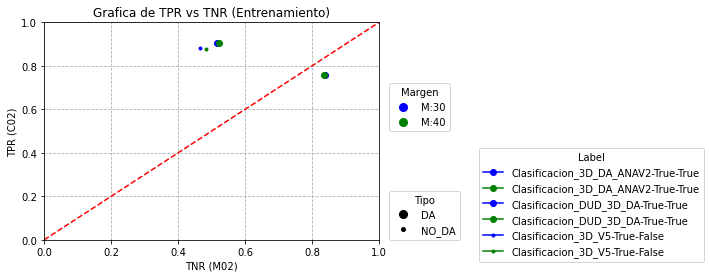

In [184]:
"""
GRAFICAS PARA CLASIFICACION
"""

limits = [[0,1],[0,1]]
dfCLAS.sort_values('acc_bal',ascending=False)
graficaClasificacion(dfCLAS,  limits,  train=True,legendName=[True,'project'])

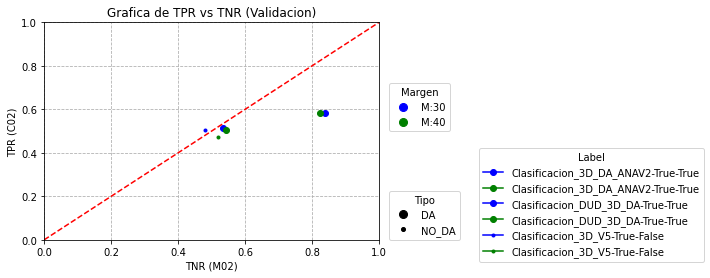

In [185]:
"""
GRAFICAS PARA CLASIFICACION
"""

limits = [[0,1],[0,1]]
dfCLAS.sort_values('acc_bal',ascending=False)
graficaClasificacion(dfCLAS,  limits,  train=False, legendName=[True,'project'])

In [175]:
"""
Analizamos un proyecto de clasifiacion a mas detalle
"""

'\nAnalizamos un proyecto de clasifiacion a mas detalle\n'

In [176]:
def analizarProject(project, criterio='acc_bal', group_by = [('M',30)] ,df= None, limits=[[0,1],[0,1]], train=False,legendName = [True,'dsName']):
    if not df:
        df = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/ReporteEstadisticas.csv')
        
    df = df[df['project']==project]
    dfTotal = df.copy()
    for g in group_by:
        df = df[df[g[0]]==g[1]]
    
   
    df = df.groupby(['dsName']).max() 
    
    columns = ['project','epoca','idModel','DA','3D','C','T','M','dsName',
               'acc_bal','loss','val_loss','val_TP','val_FP','val_FN','val_TN' ,
               'TNR','TPR','TP','FP','FN','TN','train_TNR','train_TPR','train_acc_bal']
    resultado = pd.DataFrame(columns=columns)
    
    for i in df.index:
        modelo = df['idModel'][i]
        epoca = df['epoca'][i]
        dfTemp = dfTotal[(dfTotal['idModel']==modelo) & (dfTotal['epoca']==epoca)]
        if dfTemp.empty:
            print(i)
        resultado = pd.concat([resultado,dfTemp[columns]],axis=0)
    
    if train:
        tnr = 'train_TNR'
        tpr = 'train_TPR'
        bal_acc = 'train_acc_bal'
        loss = 'loss'
    else:
        tnr = 'TNR'
        tpr = 'TPR'
        bal_acc = 'acc_bal'
        loss = 'val_loss'
    
    print(f'Se analizo el proyecto {project} agrupado por DATASET y {group_by}')
    print(f'Total de datasets: {resultado["idModel"].count()}')
    print('\n       LAS MEDIAS ARITMETICAS SON:')
    print(f'{criterio}    : {resultado[criterio].mean()}')
    print(f'TNR        : {resultado[tnr].mean()}')
    print(f'TPR        : {resultado[tpr].mean()}')
    print(f'acc_bal    : {resultado[bal_acc].mean()}')
    print(f'val_loss   : {resultado[loss].mean()}')
    
    print('\nGrafico de TPR vs TNR por cada DATASET')    
    print(f'Limites: {limits}' )
    graficaClasificacion(resultado, legenda=False, limites=limits,train=train,legendName = legendName)
        
    return resultado            

Se analizo el proyecto Clasificacion_3D_DA_ANAV2 agrupado por DATASET y [('M', 30)]
Total de datasets: 4

       LAS MEDIAS ARITMETICAS SON:
acc_bal    : 0.7077910710836391
TNR        : 0.8225806451612903
TPR        : 0.5930014970059879
acc_bal    : 0.7077910710836391
val_loss   : 6.397442057728769

Grafico de TPR vs TNR por cada DATASET
Limites: [[0, 1], [0, 1]]


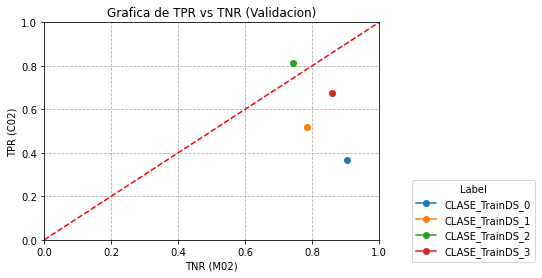

,project,epoca,idModel,DA,3D,C,T,M,dsName,acc_bal,...,val_TN,TNR,TPR,TP,FP,FN,TN,train_TNR,train_TPR,train_acc_bal
10,Clasificacion_3D_DA_ANAV2,10,20220525_122027,True,True,3,4,30,CLASE_TrainDS_0,0.634622,...,252,0.903226,0.366018,2385,987,7591,8989,0.901063,0.239074,0.570068
33,Clasificacion_3D_DA_ANAV2,11,20220525_161510,True,True,3,4,30,CLASE_TrainDS_1,0.651206,...,219,0.784946,0.517465,9976,2160,0,7816,0.78348,1.0,0.89174


In [177]:
#limits = [[0.5,1],[0.5,1]]
limits = [[0,1],[0,1]]
resultadoClas = analizarProject('Clasificacion_3D_DA_ANAV2', group_by = [('M',30)], limits=limits, train=False, legendName = [True,'dsName'])
resultadoClas.head(2)

Se analizo el proyecto Clasificacion_3D_DA_ANAV2 agrupado por DATASET y [('M', 30)]
Total de datasets: 4

       LAS MEDIAS ARITMETICAS SON:
acc_bal    : 0.7077910710836391
TNR        : 0.8332748596631917
TPR        : 0.7628057337610264
acc_bal    : 0.7980402967121091
val_loss   : 0.3870718851685524

Grafico de TPR vs TNR por cada DATASET
Limites: [[0, 1], [0, 1]]


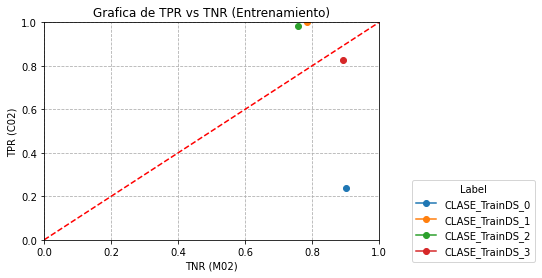

,project,DA,C,T,M,dsName,TNR,TPR,train_TNR,train_TPR
10,CLAS_3D_DA_100%,True,3,4,30,CLASE_TrainDS_0,0.903226,0.366018,0.901063,0.239074
33,CLAS_3D_DA_100%,True,3,4,30,CLASE_TrainDS_1,0.784946,0.517465,0.78348,1.0
59,CLAS_3D_DA_100%,True,3,4,30,CLASE_TrainDS_2,0.741935,0.811876,0.756716,0.985265
89,CLAS_3D_DA_100%,True,3,4,30,CLASE_TrainDS_3,0.860215,0.676647,0.89184,0.826885


In [178]:
#limits = [[0.5,1],[0.5,1]]
limits = [[0,1],[0,1]]
resultadoClas = analizarProject('Clasificacion_3D_DA_ANAV2', group_by = [('M',30)], limits=limits, train=True, legendName = [True,'dsName'])

resultadoClas['project'] = 'CLAS_3D_DA_100%'
resultadoClas = resultadoClas[['project','DA','C','T','M','dsName','TNR','TPR','train_TNR','train_TPR']]
resultadoClas

In [179]:
resultadoClas.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/ReporteEstadisticas_CLAS3D_V4.csv', index=False)

In [180]:
resultadoClas[(resultadoClas['TNR']>0.4) & (resultadoClas['TPR']>0.4)]

,project,DA,C,T,M,dsName,TNR,TPR,train_TNR,train_TPR
33,CLAS_3D_DA_100%,True,3,4,30,CLASE_TrainDS_1,0.784946,0.517465,0.78348,1.0
59,CLAS_3D_DA_100%,True,3,4,30,CLASE_TrainDS_2,0.741935,0.811876,0.756716,0.985265
89,CLAS_3D_DA_100%,True,3,4,30,CLASE_TrainDS_3,0.860215,0.676647,0.89184,0.826885
